In [1]:
# code to make heatmaps using the hidden states of an LLM!

In [2]:
# useful packages :)
!pip install transformers pandas torch
!pip install datasets hf_transfer accelerate
!pip install numpy networkx IPython
!pip install matplotlib

In [3]:
# if issues w ripser do "sudo apt remove python3-pyparsing" in terminal
!pip install ripser persim teaspoon
!pip install scikit-learn

In [4]:
# # from angelina's code:

# # ============================================
# # SETUP CELL - Run this first after pod restart
# # ============================================

# import os
# import sys

# # Add workspace packages to Python path
# workspace_packages = '/workspace/python_packages'
# if workspace_packages not in sys.path:
#     sys.path.insert(0, workspace_packages)

# # Redirect all caches to persistent workspace storage
# os.environ['HF_HOME'] = '/workspace/.cache/huggingface'
# os.environ['TRANSFORMERS_CACHE'] = '/workspace/.cache/huggingface/transformers'
# os.environ['HF_DATASETS_CACHE'] = '/workspace/.cache/huggingface/datasets'
# os.environ['TORCH_HOME'] = '/workspace/.cache/torch'
# os.environ['PIP_CACHE_DIR'] = '/workspace/.cache/pip'
# os.environ['TMPDIR'] = '/workspace/tmp'
# os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# # Create directories if they don't exist
# for path in ['/workspace/.cache/huggingface', '/workspace/.cache/torch', 
#              '/workspace/.cache/pip', '/workspace/tmp']:
#     os.makedirs(path, exist_ok=True)

# print("✓ Environment configured - all paths point to /workspace")

# # Import your libraries
# from typing import Optional, Tuple, List
# import numpy as np
# import torch
# from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
# from datasets import load_dataset
# from ripser import ripser
# from persim import plot_diagrams, bottleneck
# import matplotlib.pyplot as plt
# import seaborn as sns
# import textwrap

# print("✓ All libraries imported successfully")
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
from ripser import ripser
from tqdm import tqdm
import math
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# should first do the following in terminal:
# 1. pip install huggingface_hub
# 2. huggingface-cli login --token <access_token>
# alt 2. hf auth login

# load in llama!
model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
                model_id,
                torch_dtype=torch.float16,
                device_map="auto",
            )

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


In [7]:
# # llama tokenizing test
# # fix CUDA error (?) with "pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128"
# test = "This is a test sentence."
# inputs = tokenizer(text = test, truncation=True, return_tensors="pt").to(model.device)

# with torch.no_grad():
#     outputs = model(**inputs, output_hidden_states=True)
# first_hidden_state_tuple = outputs.hidden_states[0]
# print(first_hidden_state_tuple)

# if first_hidden_state_tuple.ndim > 2:
#     first_hidden_state_tuple = first_hidden_state_tuple.reshape(-1, first_hidden_state_tuple.shape[-1])
# print(first_hidden_state_tuple)

# # fit + transform PCA with 2 components
# test_embeddings = PCA(n_components=2).fit_transform(first_hidden_state_tuple)
# print(test_embeddings)

In [8]:
def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf


def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]

In [9]:
def extract_attention_matrices(model, enc_inputs, layer: Optional[int]=None, head: Optional[int]=None):
    """
    Runs model and returns attention maps of shape:
      (num_layers, batch, num_heads, seq_len, seq_len)
    If layer/head are set, returns the selection.
    """
    with torch.no_grad():
        outputs = model(**enc_inputs, output_attentions=True, return_dict=True)
    
    # outputs.attentions is a tuple (one per layer) each (batch, num_heads, seq_len, seq_len)
    attentions = outputs.attentions  # tuple of length num_layers
    
    # stack into array: (num_layers, batch, num_heads, seq, seq)
    attn_stack = torch.stack(attentions, dim=0)  # (num_layers, batch, heads, seq, seq)
    
    # optionally select layer or head
    if layer is not None:
        attn_stack = attn_stack[layer:layer+1]  # keep dims
    if head is not None:
        # reduce heads dimension to single head
        attn_stack = attn_stack[:, :, head:head+1, :, :]
    
    # convert to numpy (cpu)
    return attn_stack.cpu().numpy()
def attention_to_distance(attn: np.ndarray, symmetrize: str='avg') -> np.ndarray:
    """
    Convert an attention matrix (seq_len x seq_len) to a distance matrix suitable for ripser.
    attn: 2D numpy array (seq_len, seq_len) representing one attention map.
    symmetrize: 'avg' ( (a + a.T)/2 ), 'max', or 'none' (use as-is then force symmetric via avg)
    Returns: symmetric distance matrix (seq_len, seq_len)
    """
    if attn.ndim != 2:
        raise ValueError("attn must be 2D")
    
    # ensure nonnegative and normalized to [0,1]
    A = attn.copy()
    # sometimes attention rows sum to 1 (softmax axis= -1). We'll clip/normalize to [0,1]
    A = np.nan_to_num(A)
    A -= A.min()
    if A.max() > 0:
        A = A / A.max()
    
    # symmetrize
    if symmetrize == 'avg':
        S = 0.5 * (A + A.T)
    elif symmetrize == 'max':
        S = np.maximum(A, A.T)
    else:
        S = 0.5 * (A + A.T)
    
    # convert similarity -> distance
    D = 1.0 - S
    # set zeros on diagonal
    np.fill_diagonal(D, 0.0)
    
    return D
    

def compute_tda_features(distance_matrix):
    diagrams = ripser(distance_matrix,distance_matrix=True, maxdim=1)['dgms']

    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = np.count_nonzero(np.round(h0)) #count_nonzero(h0) #len(h0)
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    # Replace inf values with 0
    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0
    # print("mean h0: ", mean_h0)


    num_h1 = np.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    # Replace inf values with 0
    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0
    # print("mean h1: ", mean_h1)

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])

    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    # Additional TDA features for linguistic correlation
    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)


    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]
    
def process_texts(texts):
    model_id = "meta-llama/Llama-3.1-8B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
                model_id,
                torch_dtype = torch.float16,
                device_map="auto",
            )

    data = []
    for text in tqdm(texts):
        hidden_states = get_llama_embeddings(text, model, tokenizer).cpu().detach().numpy()
        # print(hidden_states)
        graph = build_graph_embeddings(hidden_states)
        tda_features = compute_tda_features(graph)
        data.append(tda_features)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

# Example usage
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts)
print(df)


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]
Some parameters are on the meta device because they were offloaded to the cpu.
100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         2  0.626674               0.616130   0.098853              7   
1         3  0.587276               0.558865   0.101419              7   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.176795         0         0                      0   
1               1.269305         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0  
1          0              1                   -0.0  


In [10]:
# import dataset!!
# datasets[0]: BLIMP, datasets[1]: windograd
# datasets = ["/workspace/tda_vs_linguistics 2/data/nyu_mll_blimp.csv", "/workspace/tda_vs_linguistics 2/data/nyu_winograd_wsc.csv"]
datasets = ["~/tda_vs_linguistics/data/nyu_mll_blimp.csv", "~/tda_vs_linguistics/data/nyu_winograd_wsc.csv"]
dataset = datasets[0]
number_sentences = 500

# automatically change name of data stored
dataset_name = ""
label_good = ""
label_bad = ""
title1 = ""
title2 = ""
if dataset == datasets[0]:
    dataset_name = "BLIMP"
    label_good = "sentence_good"
    label_bad = "sentence_bad"
    title1 = "Gramatically Correct Sentences"
    title2 = "Gramatically Incorrect Sentences"
elif dataset == datasets[1]:
    dataset_name = "winograd"
    label_good = "sentence1"
    label_bad = "sentence2"
    title1 = "Sentences Referencing Sooner Tokens"
    title2 = "Sentences Referencing Later Tokens"

data_sen_pairs = pd.read_csv(dataset)
sen_good = data_sen_pairs[label_good][0:number_sentences]
sen_bad = data_sen_pairs[label_bad][0:number_sentences]

data_sen_pairs.head()

,sentence_good,sentence_bad,field,linguistics_term,UID,simple_LM_method,one_prefix_method,two_prefix_method,lexically_identical,pair_id
0,Who should Derek hug after shocking Richard?,Who should Derek hug Richard after shocking?,syntax,island_effects,adjunct_island,True,False,False,True,0
1,What had Theresa walked through while talking ...,What had Theresa walked through that high scho...,syntax,island_effects,adjunct_island,True,False,False,True,1
2,Who will Katherine discover without hiring Erin?,Who will Katherine discover Erin without hiring?,syntax,island_effects,adjunct_island,True,False,False,True,2
3,Who has Colleen aggravated before kissing Judy?,Who has Colleen aggravated Judy before kissing?,syntax,island_effects,adjunct_island,True,False,False,True,3
4,What could a lot of cats break while finding a...,What could a lot of cats break all convertible...,syntax,island_effects,adjunct_island,True,False,False,True,4


In [11]:
# good_tda = process_texts(sen_good)
# good_tda
# good_tda.to_csv(f"/workspace/tda_vs_linguistics/{dataset_name}/{dataset_name}_good_tda.csv", index=False)
good_tda = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{dataset_name}_good_tda.csv")
good_tda

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,betti_curve_0,persistence_entropy_0,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim,betti_curve_1,persistence_entropy_1
0,3,0.642257,0.630468,0.102103,9,1.527863,0,0,0,0,1,-0.0
1,2,0.778035,0.771230,0.056445,13,1.640243,0,0,0,0,1,-0.0
2,3,0.764606,0.741611,0.103494,9,1.318319,0,0,0,0,1,-0.0
3,3,0.767017,0.753821,0.093903,10,1.358362,0,0,0,0,1,-0.0
4,3,0.645406,0.632563,0.053027,14,1.497047,0,0,0,0,1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0.453704,0.000000,0.070835,1,-0.000000,0,0,0,0,1,-0.0
496,3,0.780217,0.768753,0.080010,11,1.076831,0,0,0,0,1,-0.0
497,3,0.767039,0.748322,0.088112,10,1.240559,0,0,0,0,1,-0.0
498,3,0.681366,0.666094,0.086519,10,1.593232,0,0,0,0,1,-0.0


In [12]:
# bad_tda = process_texts(sen_bad)
# bad_tda
# bad_tda.to_csv(f"/workspace/tda_vs_linguistics/{dataset_name}/{dataset_name}_bad_tda.csv", index=False)
bad_tda = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{dataset_name}_bad_tda.csv")
bad_tda

,Num_0dim,Max_0dim,Max_0dim_Minus_Second,Mean_0dim,betti_curve_0,persistence_entropy_0,Num_1dim,Max_1dim,Max_1dim_Minus_Second,Mean_1dim,betti_curve_1,persistence_entropy_1
0,3,0.642257,0.630468,0.102103,9,1.527863,0,0,0,0,1,-0.0
1,2,0.778035,0.771230,0.056445,13,1.640243,0,0,0,0,1,-0.0
2,3,0.764606,0.741611,0.103494,9,1.318319,0,0,0,0,1,-0.0
3,3,0.767017,0.753821,0.093903,10,1.358362,0,0,0,0,1,-0.0
4,3,0.645314,0.632602,0.052998,14,1.495154,0,0,0,0,1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0.453704,0.000000,0.070835,1,-0.000000,0,0,0,0,1,-0.0
496,3,0.780217,0.768753,0.080010,11,1.076831,0,0,0,0,1,-0.0
497,3,0.767039,0.748322,0.088112,10,1.240559,0,0,0,0,1,-0.0
498,3,0.681366,0.666094,0.086519,10,1.593232,0,0,0,0,1,-0.0


In [13]:
# downloads for second half!
!pip install textdescriptives
!pip install spacy
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.5 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy
import textdescriptives as td
# load your favourite spacy model (remember to install it first using e.g. `python -m spacy download en_core_web_sm`)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")

def get_desc(data):
  doc = nlp(data.iloc[0])
  df1 = td.extract_df(doc)

  for text in tqdm(data.iloc[1:]):
    text = nlp(text)
    df2 = td.extract_df(text)
    df1 = df1._append(df2)

  return df1

In [15]:
# good_feat = get_desc(sen_good)
# bad_feat = get_desc(sen_bad)
# good_feat.to_csv(f"/workspace/tda_vs_linguistics/{dataset_name}/{dataset_name}_good_feat.csv")
# bad_feat.to_csv(f"/workspace/tda_vs_linguistics/{dataset_name}/{dataset_name}_bad_feat.csv")
good_feat = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{dataset_name}_good_feat.csv")
bad_feat = pd.read_csv(f"~/tda_vs_linguistics/{dataset_name}/{dataset_name}_bad_feat.csv")
good_feat

,Unnamed: 0,text,token_length_mean,token_length_median,token_length_std,sentence_length_mean,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,...,prop_adjacent_dependency_relation_mean,prop_adjacent_dependency_relation_std,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix
0,0,Who should Derek hug after shocking Richard?,5.285714,5.0,1.749636,7.0,7.0,0.0,1.142857,1.0,...,0.500000,0.0,103.044286,0.625714,NaN,2.800000,6.965714,11.051429,35.571429,2.0
1,0,What had Theresa walked through while talking ...,5.272727,5.0,1.354515,11.0,11.0,0.0,1.090909,1.0,...,0.416667,0.0,103.379091,1.572727,NaN,4.400000,8.904545,12.512727,38.272727,3.0
2,0,Who will Katherine discover without hiring Erin?,5.857143,6.0,2.099563,7.0,7.0,0.0,1.714286,1.0,...,0.500000,0.0,54.701429,7.368571,NaN,14.228571,9.657143,14.411429,49.857143,3.0
3,0,Who has Colleen aggravated before kissing Judy?,5.714286,6.0,2.373321,7.0,7.0,0.0,1.571429,1.0,...,0.625000,0.0,66.787143,5.682857,NaN,8.514286,8.984286,13.571429,49.857143,3.0
4,0,What could a lot of cats break while finding a...,4.636364,4.0,2.804954,11.0,11.0,0.0,1.272727,1.0,...,0.416667,0.0,87.997273,3.718182,NaN,8.036364,5.907273,8.770909,29.181818,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,Who can the man respect before helping Janice?,4.750000,4.5,1.785357,8.0,8.0,0.0,1.375000,1.0,...,0.555556,0.0,82.390000,3.755000,NaN,3.200000,4.942500,8.430000,33.000000,2.0
496,0,What was Alicia going to after disgusting all ...,5.222222,5.0,2.572408,9.0,9.0,0.0,1.555556,1.0,...,0.400000,0.0,66.100000,6.275556,NaN,12.488889,7.666667,11.617778,31.222222,2.0
497,0,Who has Becky visited while confusing most dri...,5.375000,5.0,1.996090,8.0,8.0,0.0,1.375000,1.0,...,0.333333,0.0,82.390000,3.755000,NaN,8.200000,7.886250,12.105000,45.500000,3.0
498,0,Who should most guests hate after hiding Dan?,4.625000,4.5,1.218349,8.0,8.0,0.0,1.125000,1.0,...,0.555556,0.0,103.540000,0.805000,NaN,3.200000,4.353750,7.695000,8.000000,0.0


In [16]:
column_labels_list = good_feat.columns.tolist()
print(column_labels_list.index("doc_length"))
print(column_labels_list.index("pos_prop_ADP"))
print(column_labels_list.index("first_order_coherence"))
print(column_labels_list.index("second_order_coherence"))
print(column_labels_list.index("smog"))
print(column_labels_list)

20
38
57
58
65
['Unnamed: 0', 'text', 'token_length_mean', 'token_length_median', 'token_length_std', 'sentence_length_mean', 'sentence_length_median', 'sentence_length_std', 'syllables_per_token_mean', 'syllables_per_token_median', 'syllables_per_token_std', 'n_tokens', 'n_unique_tokens', 'proportion_unique_tokens', 'n_characters', 'n_sentences', 'passed_quality_check', 'n_stop_words', 'alpha_ratio', 'mean_word_length', 'doc_length', 'symbol_to_word_ratio_#', 'proportion_ellipsis', 'proportion_bullet_points', 'contains_lorem ipsum', 'duplicate_line_chr_fraction', 'duplicate_paragraph_chr_fraction', 'duplicate_ngram_chr_fraction_5', 'duplicate_ngram_chr_fraction_6', 'duplicate_ngram_chr_fraction_7', 'duplicate_ngram_chr_fraction_8', 'duplicate_ngram_chr_fraction_9', 'duplicate_ngram_chr_fraction_10', 'top_ngram_chr_fraction_2', 'top_ngram_chr_fraction_3', 'top_ngram_chr_fraction_4', 'oov_ratio', 'pos_prop_ADJ', 'pos_prop_ADP', 'pos_prop_ADV', 'pos_prop_AUX', 'pos_prop_CCONJ', 'pos_prop

In [17]:
tda_list = good_tda.columns.tolist()
print(tda_list)

['Num_0dim', 'Max_0dim', 'Max_0dim_Minus_Second', 'Mean_0dim', 'betti_curve_0', 'persistence_entropy_0', 'Num_1dim', 'Max_1dim', 'Max_1dim_Minus_Second', 'Mean_1dim', 'betti_curve_1', 'persistence_entropy_1']


In [18]:
# ## from Catherine's code ##
# def compute_additional_features(texts):
#     """
#     Compute additional linguistic features specifically suited for short sentences.
#     Focus on syntactic and structural properties relevant to island effects.
#     """
#     features_list = []
    
#     for text in tqdm(texts, desc="Computing additional features"):
#         doc = nlp(text)
        
#         features = {}
        
#         # ===== DEPENDENCY STRUCTURE FEATURES =====
#         # Average dependency distance (how far apart are syntactic dependencies?)
#         dep_distances = []
#         for token in doc:
#             if token.head != token:
#                 dep_distances.append(abs(token.i - token.head.i))
#         features['avg_dependency_distance'] = np.mean(dep_distances) if dep_distances else 0
#         features['max_dependency_distance'] = max(dep_distances) if dep_distances else 0
#         features['total_dependency_distance'] = sum(dep_distances) if dep_distances else 0
        
#         # Tree depth (how deep is the parse tree?)
#         def get_tree_depth(token):
#             if not list(token.children):
#                 return 1
#             return 1 + max(get_tree_depth(child) for child in token.children)
        
#         root_tokens = [token for token in doc if token.dep_ == 'ROOT']
#         features['tree_depth'] = max([get_tree_depth(root) for root in root_tokens]) if root_tokens else 0
        
#         # Count of different dependency relations
#         dep_types = Counter([token.dep_ for token in doc])
#         features['n_dependency_types'] = len(dep_types)
        
#         # ===== WH-MOVEMENT FEATURES (Critical for island effects!) =====
#         wh_words = ['who', 'what', 'where', 'when', 'why', 'how', 'which']
#         features['has_wh_word'] = int(any(token.text.lower() in wh_words for token in doc))
#         features['wh_word_position'] = next((token.i for token in doc if token.text.lower() in wh_words), -1)
        
#         # Distance from wh-word to main verb
#         if features['wh_word_position'] >= 0:
#             main_verbs = [token.i for token in doc if token.pos_ == 'VERB' and token.dep_ in ['ROOT', 'ccomp', 'xcomp']]
#             if main_verbs:
#                 features['wh_to_verb_distance'] = min([abs(features['wh_word_position'] - v) for v in main_verbs])
#             else:
#                 features['wh_to_verb_distance'] = 0
#         else:
#             features['wh_to_verb_distance'] = 0
        
#         # ===== CLAUSE STRUCTURE =====
#         # Count subordinate clauses (adjuncts!)
#         subordinate_markers = ['after', 'before', 'while', 'although', 'because', 'if', 'when', 'since', 'until']
#         features['n_subordinate_markers'] = sum(1 for token in doc if token.text.lower() in subordinate_markers)
#         features['subordinate_marker_position'] = next((token.i for token in doc if token.text.lower() in subordinate_markers), -1)
        
#         # Count clauses (approximate by counting verbs)
#         features['n_clauses'] = sum(1 for token in doc if token.pos_ == 'VERB')
        
#         # Subordinate clause depth (position relative to sentence length)
#         if features['subordinate_marker_position'] >= 0:
#             features['subordinate_relative_position'] = features['subordinate_marker_position'] / len(doc)
#         else:
#             features['subordinate_relative_position'] = 0
        
#         # ===== VERB FEATURES =====
#         verbs = [token for token in doc if token.pos_ == 'VERB']
#         features['n_verbs'] = len(verbs)
        
#         # Verb forms
#         verb_forms = Counter([token.tag_ for token in verbs])
#         features['n_gerunds'] = verb_forms.get('VBG', 0)  # -ing forms (e.g., "shocking")
#         features['n_past_participles'] = verb_forms.get('VBN', 0)
#         features['n_base_verbs'] = verb_forms.get('VB', 0)
        
#         # ===== PREPOSITION FEATURES (Critical for adjunct islands!) =====
#         prepositions = [token for token in doc if token.pos_ == 'ADP']
#         features['n_prepositions'] = len(prepositions)
        
#         # Distance between prepositions
#         if len(prepositions) >= 2:
#             prep_distances = [prepositions[i+1].i - prepositions[i].i for i in range(len(prepositions)-1)]
#             features['avg_prep_distance'] = np.mean(prep_distances)
#         else:
#             features['avg_prep_distance'] = 0
        
#         # Position of first preposition
#         features['first_prep_position'] = prepositions[0].i if prepositions else -1
#         features['first_prep_relative_position'] = (prepositions[0].i / len(doc)) if prepositions else 0
        
#         # ===== NOUN PHRASE FEATURES =====
#         noun_chunks = list(doc.noun_chunks)
#         features['n_noun_phrases'] = len(noun_chunks)
        
#         if noun_chunks:
#             features['avg_noun_phrase_length'] = np.mean([len(chunk) for chunk in noun_chunks])
#             features['max_noun_phrase_length'] = max([len(chunk) for chunk in noun_chunks])
#         else:
#             features['avg_noun_phrase_length'] = 0
#             features['max_noun_phrase_length'] = 0
        
#         # ===== WORD ORDER FEATURES =====
#         # Check for inverted word order (common in questions)
#         features['starts_with_wh'] = int(doc[0].text.lower() in wh_words if len(doc) > 0 else 0)
#         features['starts_with_aux'] = int(doc[0].pos_ == 'AUX' if len(doc) > 0 else 0)
        
#         # Subject-verb distance
#         subjects = [token for token in doc if 'subj' in token.dep_]
#         verbs = [token for token in doc if token.pos_ == 'VERB']
#         if subjects and verbs:
#             subj_verb_distances = [abs(subj.i - verb.i) for subj in subjects for verb in verbs]
#             features['min_subj_verb_distance'] = min(subj_verb_distances)
#             features['avg_subj_verb_distance'] = np.mean(subj_verb_distances)
#         else:
#             features['min_subj_verb_distance'] = 0
#             features['avg_subj_verb_distance'] = 0
        
#         # ===== EXTRACTION/MOVEMENT INDICATORS =====
#         # Gap detection: look for traces of movement
#         # In "Who should Derek hug __?", there's a gap after "hug"
        
#         # Count objects that could be extraction sites
#         objects = [token for token in doc if token.dep_ in ['dobj', 'pobj', 'obj']]
#         features['n_objects'] = len(objects)
        
#         # Distance from wh-word to potential gap
#         if features['wh_word_position'] >= 0 and objects:
#             gap_distances = [abs(features['wh_word_position'] - obj.i) for obj in objects]
#             features['wh_to_gap_distance'] = min(gap_distances)
#         else:
#             features['wh_to_gap_distance'] = 0
        
#         # ===== PUNCTUATION FEATURES =====
#         features['has_question_mark'] = int('?' in text)
#         features['n_commas'] = text.count(',')
        
#         # ===== LENGTH FEATURES =====
#         features['sentence_length'] = len(doc)
#         features['n_words'] = len([token for token in doc if not token.is_punct])
        
#         # Average word length
#         word_lengths = [len(token.text) for token in doc if not token.is_punct]
#         features['avg_word_length'] = np.mean(word_lengths) if word_lengths else 0
        
#         # ===== SPECIFIC ISLAND VIOLATION INDICATORS =====
#         # Check for the pattern: "wh-word ... preposition ... verb-ing"
#         # This is the adjunct island structure
#         if features['has_wh_word'] and features['n_subordinate_markers'] > 0:
#             wh_pos = features['wh_word_position']
#             sub_pos = features['subordinate_marker_position']
#             gerunds = [token.i for token in doc if token.tag_ == 'VBG']
            
#             # Pattern: wh-word appears before subordinate clause with gerund
#             if gerunds and wh_pos >= 0 and sub_pos >= 0:
#                 features['island_pattern'] = int(wh_pos < sub_pos < min(gerunds))
#             else:
#                 features['island_pattern'] = 0
#         else:
#             features['island_pattern'] = 0
        
#         features_list.append(features)
    
#     return pd.DataFrame(features_list)

In [19]:
# from collections import Counter

# additional_good = compute_additional_features(sen_good)
# additional_bad = compute_additional_features(sen_bad)

In [20]:
# heatmap labels
linguistic_labels = [['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens'],
                    ['avg_dependency_distance', 'max_dependency_distance', 'tree_depth',
                              'wh_to_verb_distance', 'n_subordinate_markers', 'subordinate_relative_position',
                              'n_gerunds', 'n_prepositions', 'first_prep_relative_position',
                              'wh_to_gap_distance', 'island_pattern', 'avg_subj_verb_distance']]
tda_labels = [["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"], tda_list[:6]]

linguistic_label = column_labels_list[3:] # column_labels_list[3:21] + column_labels_list[38:57] + column_labels_list[59:65] + column_labels_list[66:] # linguistic_labels[0]
tda_label = tda_list # tda_labels[1]

focus_good_feat = good_feat[linguistic_label]
focus_bad_feat = bad_feat[linguistic_label]
# focus_good_feat = additional_good[linguistic_label]
# focus_bad_feat = additional_bad[linguistic_label]

focus_tda_good = good_tda[tda_label]
focus_tda_bad = bad_tda[tda_label]

In [21]:
# final download forgot earlier :0
!pip install dcor
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Red cells (row, col, value):
('Mean_0dim', 'sentence_length_mean', 0.7507707276025727)
('Mean_0dim', 'sentence_length_median', 0.7507707276025727)
('Mean_0dim', 'n_tokens', 0.7507707276025727)
('Mean_0dim', 'n_unique_tokens', 0.7500521283485577)
('Mean_0dim', 'n_characters', 0.5399152994139028)
('Mean_0dim', 'passed_quality_check', 0.6718092034635248)
('Mean_0dim', 'n_stop_words', 0.7145375856214444)
('Mean_0dim', 'alpha_ratio', 0.7490927093241206)
('Mean_0dim', 'doc_length', 0.7507707276025793)
('Mean_0dim', 'pos_prop_DET', 0.5109442192420731)
('Mean_0dim', 'pos_prop_PRON', 0.7420696432169297)
('Mean_0dim', 'pos_prop_PROPN', 0.6008344417269939)
('Mean_0dim', 'pos_prop_PUNCT', 0.7490927093281943)
('Mean_0dim', 'entropy', 0.5141014978300933)
('Mean_0dim', 'perplexity', 0.5130756130532761)
('Mean_0dim', 'per_word_perplexity', 0.6482007354622928)
('betti_curve_0', 'sentence_length_mean', 0.7310189247760065)
('betti_curve_0', 'sentence_length_median', 0.7310189247760065)
('betti_curve_0', 

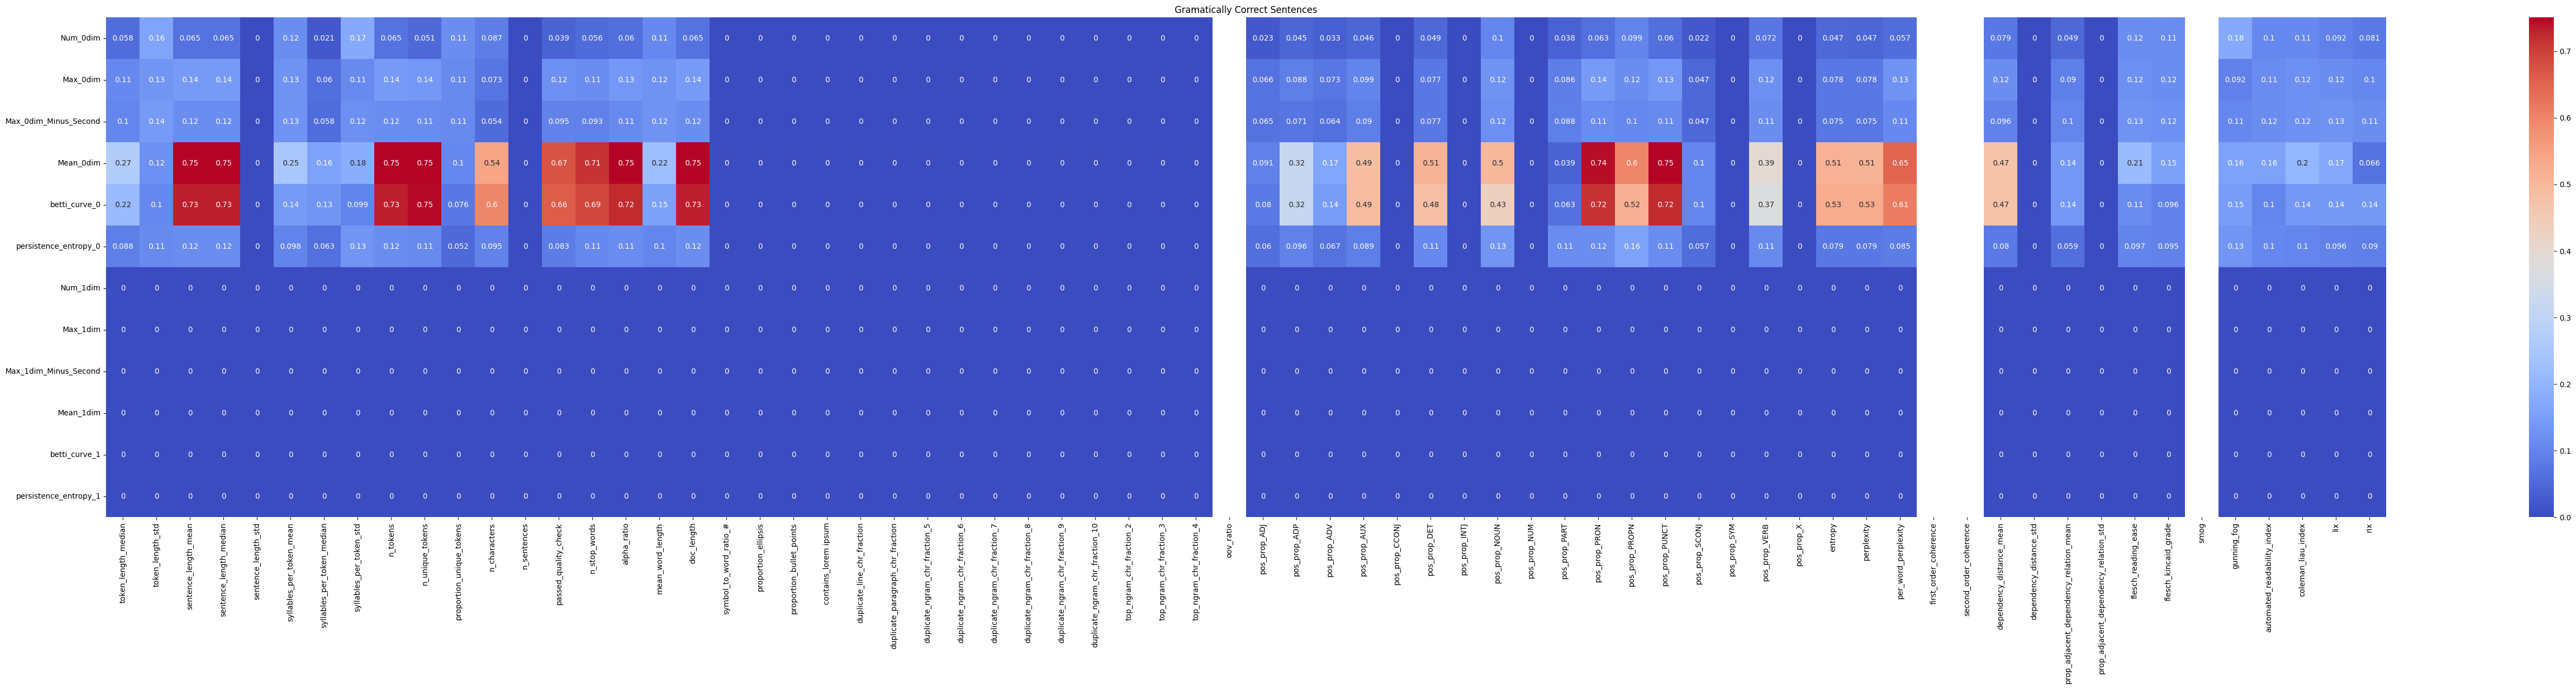

In [25]:
from dcor import distance_correlation
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
import os

# convert features to numpy
tda_features = focus_tda_good.to_numpy()
linguistic_features = focus_good_feat.to_numpy()

# compute pairwise distance correlation matrix
corr_matrix = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# plot heatmap
plt.figure(figsize=(len(linguistic_label), len(tda_label)))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",
            xticklabels= linguistic_label,
            yticklabels= tda_label
            )


plt.title(f"{title1}")

# find highest correlated values
red_threshold=0.5
red_cells = [(tda_label[i], linguistic_label[j], corr_matrix[i, j]) 
             for i in range(corr_matrix.shape[0])
             for j in range(corr_matrix.shape[1])
             if (corr_matrix[i, j] > red_threshold)]

print("Red cells (row, col, value):")
for cell in red_cells:
    print(cell)

attempt = 3
path_good = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{dataset_name}_sen_good{attempt}.pdf")

plt.savefig(path_good)
plt.show()

#Distance Correlation Heatmap

/home/klopez/tda_vs_linguistics/mitll2/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(pyobject, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Red cells (row, col, value):
('Mean_0dim', 'sentence_length_mean', 0.7507707276025727)
('Mean_0dim', 'sentence_length_median', 0.7507707276025727)
('Mean_0dim', 'n_tokens', 0.7507707276025727)
('Mean_0dim', 'n_unique_tokens', 0.7500521283485577)
('Mean_0dim', 'n_characters', 0.5399152994139028)
('Mean_0dim', 'passed_quality_check', 0.6718092034635248)
('Mean_0dim', 'n_stop_words', 0.7145375856214444)
('Mean_0dim', 'alpha_ratio', 0.7490927093241206)
('Mean_0dim', 'doc_length', 0.7507707276025793)
('Mean_0dim', 'pos_prop_AUX', 0.4882064585474958)
('Mean_0dim', 'pos_prop_DET', 0.5109442192420731)
('Mean_0dim', 'pos_prop_NOUN', 0.49974918358367326)
('Mean_0dim', 'pos_prop_PRON', 0.7420696432169297)
('Mean_0dim', 'pos_prop_PROPN', 0.6008344417269939)
('Mean_0dim', 'pos_prop_PUNCT', 0.7490927093281943)
('Mean_0dim', 'entropy', 0.5141014978300933)
('Mean_0dim', 'perplexity', 0.5130756130532761)
('Mean_0dim', 'per_word_perplexity', 0.6482007354622928)
('betti_curve_0', 'sentence_length_mean', 

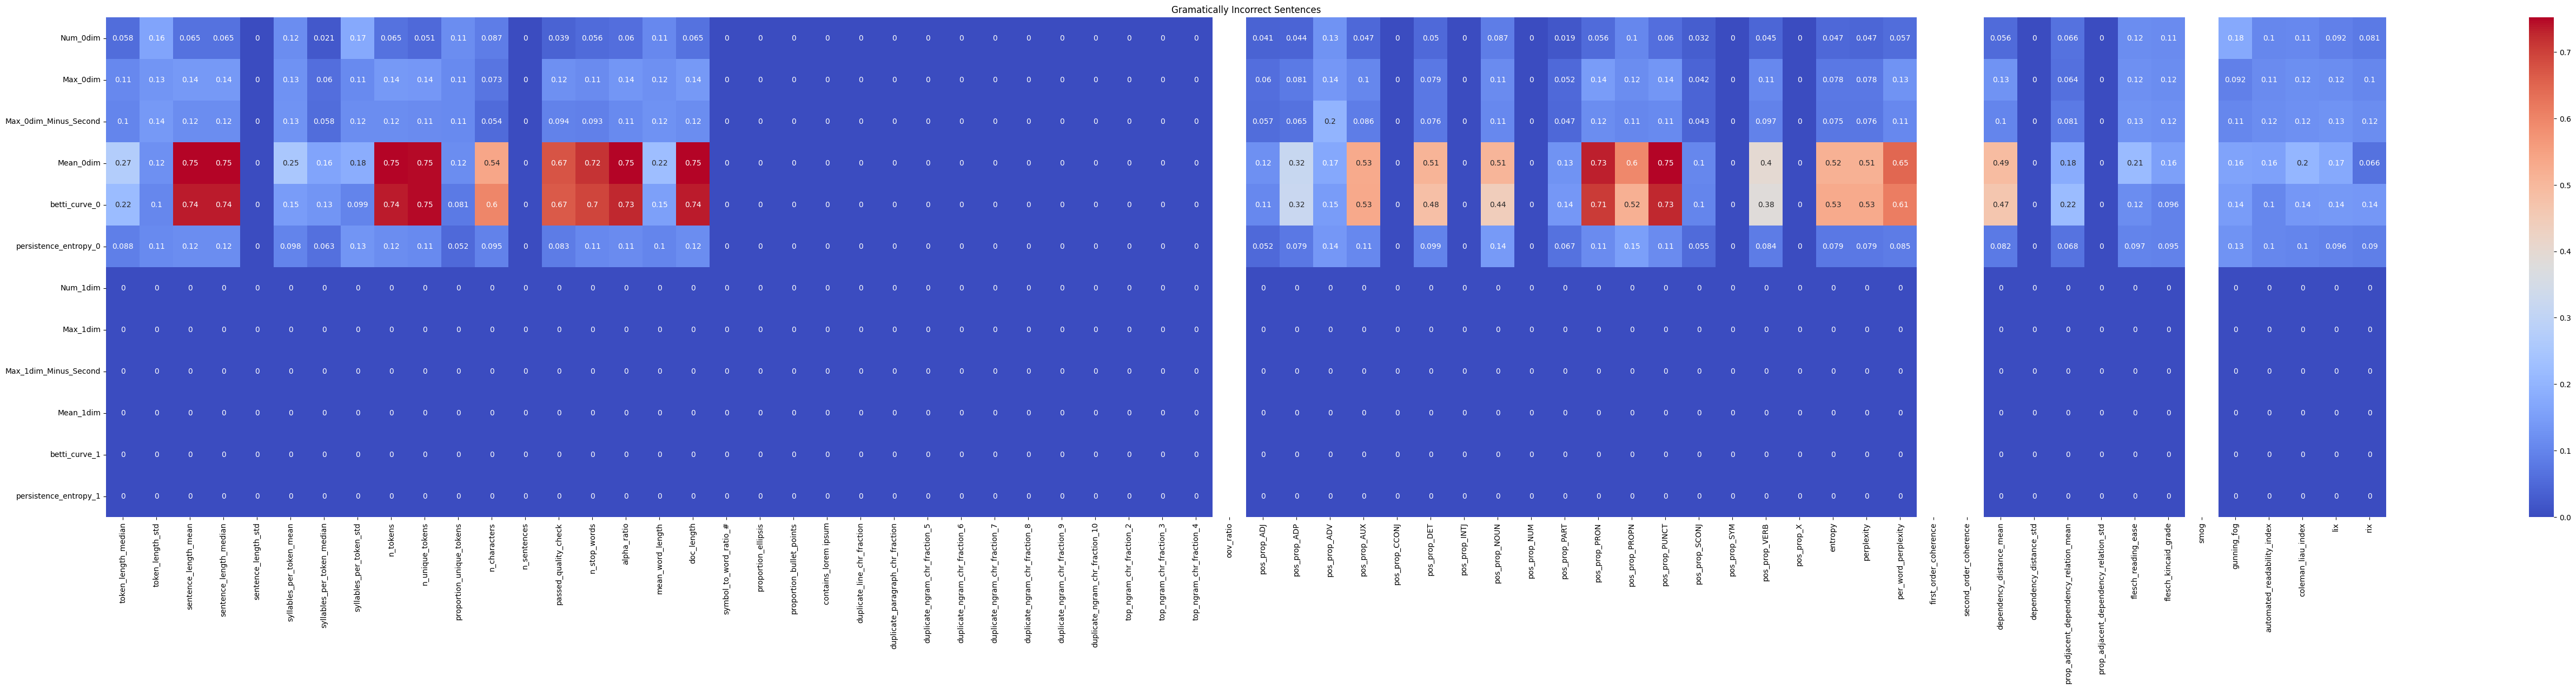

In [26]:
# convert features to numpy
tda_features2 = focus_tda_bad.to_numpy()
linguistic_features2 = focus_bad_feat.to_numpy()

# compute pairwise distance correlation matrix
corr_matrix2 = np.zeros((tda_features2.shape[1], linguistic_features2.shape[1]))

for i in range(tda_features2.shape[1]):
    for j in range(linguistic_features2.shape[1]):
        corr_matrix2[i, j] = dcor.distance_correlation(tda_features2[:, i], linguistic_features2[:, j])

# plot heatmap
plt.figure(figsize=(len(linguistic_label), len(tda_label)))
sns.heatmap(corr_matrix2, annot=True, cmap="coolwarm",
            xticklabels= linguistic_label,
            yticklabels= tda_label
            )

# find highest correlated values
red_threshold=0.5
red_cells2 = [(tda_label[i], linguistic_label[j], corr_matrix[i, j]) 
             for i in range(corr_matrix2.shape[0])
             for j in range(corr_matrix2.shape[1])
             if (corr_matrix2[i, j] > red_threshold)]

print("Red cells (row, col, value):")
for cell in red_cells2:
    print(cell)

path_bad = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{dataset_name}_sen_bad{attempt}.pdf")

plt.title(f"{title2}")
plt.savefig(path_bad)
plt.show()

#Distance Correlation Heatmap

Red cells (row, col, value):


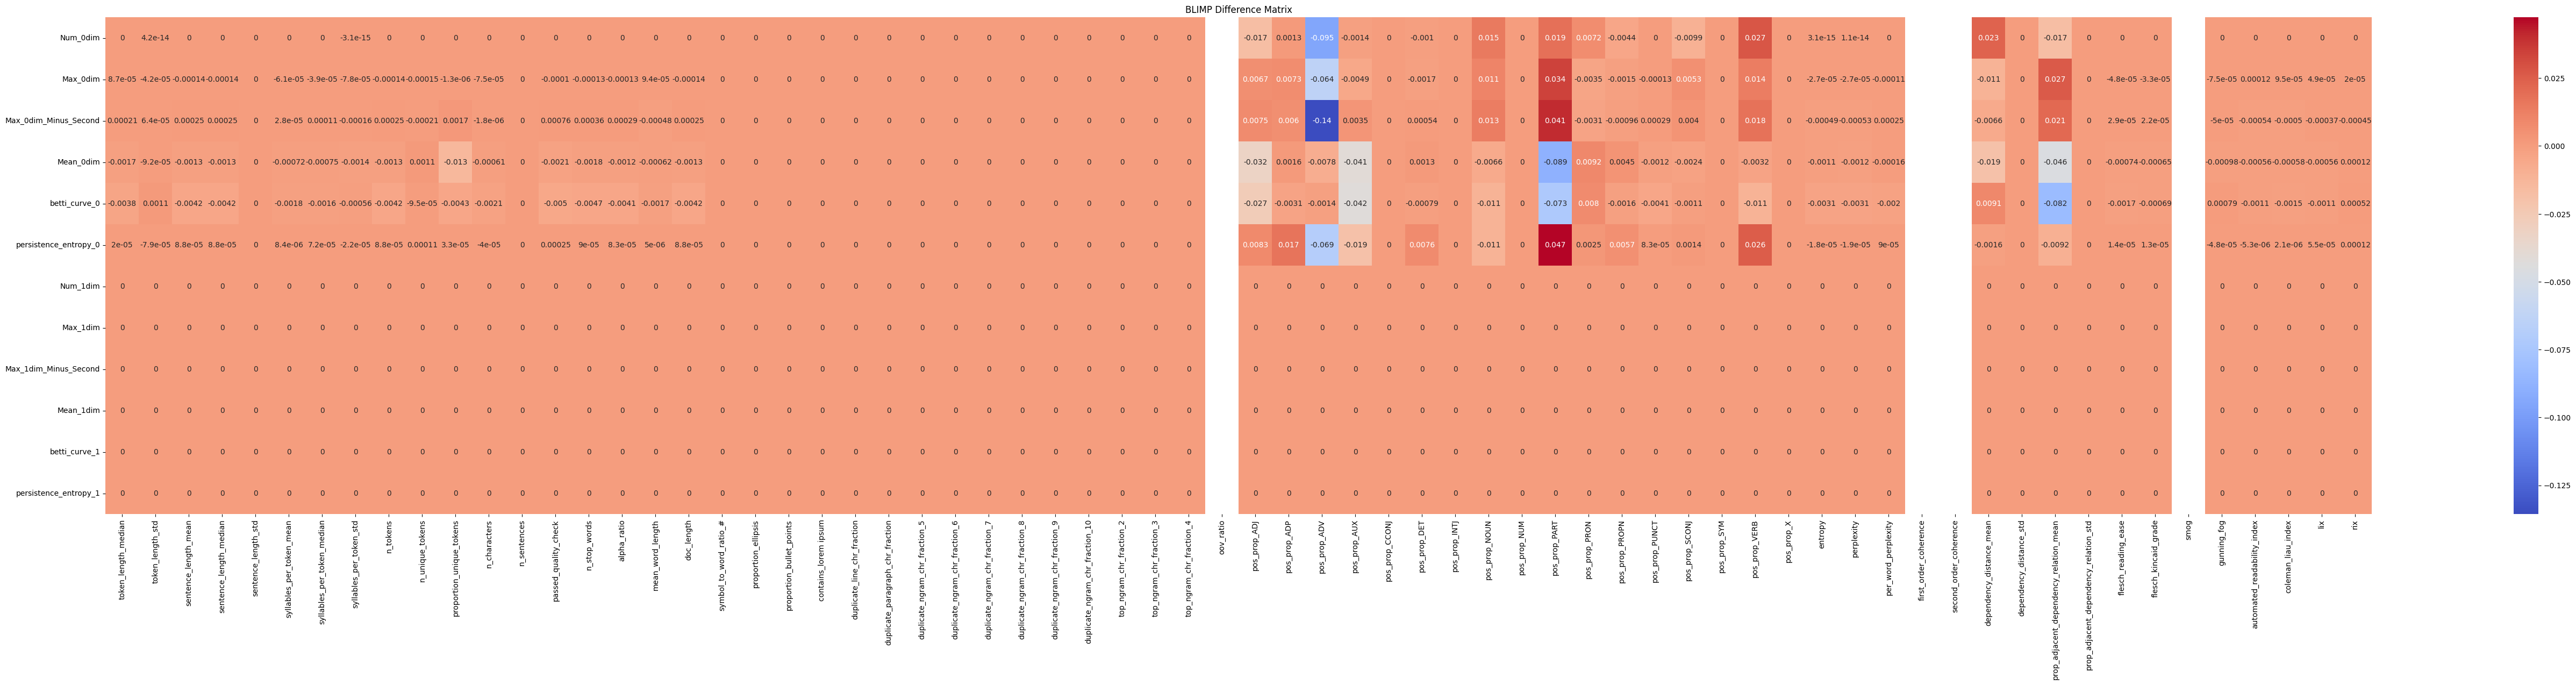

In [28]:
# difference matrix

# compute pairwise distance correlation matrix
corr_matrix3 = corr_matrix - corr_matrix2

# plot heatmap
plt.figure(figsize=(len(linguistic_label), len(tda_label)))
sns.heatmap(corr_matrix3, annot=True, cmap="coolwarm",
            xticklabels= linguistic_label,
            yticklabels=tda_label
            )

# find highest correlated values
red_threshold=0.5
red_cells3 = [(tda_label[i], linguistic_label[j], corr_matrix3[i, j]) 
             for i in range(corr_matrix3.shape[0])
             for j in range(corr_matrix3.shape[1])
             if (corr_matrix3[i, j] > red_threshold)]

print("Red cells (row, col, value):")
for cell in red_cells3:
    print(cell)

plt.title(f"{dataset_name} Difference Matrix")

path_diff = os.path.expanduser(f"~/tda_vs_linguistics/{dataset_name}/heatmaps/{dataset_name}_sen_diff{attempt}.pdf")

plt.savefig(path_diff)
plt.show()

#Distance Correlation Heatmap